# Spatial Modelling with SPDEs

## Data preprocessing
In the following, we are going to work with the `meuse` dataset. This dataset
contains measurements of zinc concentrations in the soil near the Meuse river.

We begin by downloading the dataset.

In [1]:
meuse_path = joinpath(@__DIR__, "meuse.csv")
meuse_URL = "https://gist.githubusercontent.com/essicolo/91a2666f7c5972a91bca763daecdc5ff/raw/056bda04114d55b793469b2ab0097ec01a6d66c6/meuse.csv"
download(meuse_URL, meuse_path)

"/home/runner/work/GaussianMarkovRandomFields.jl/GaussianMarkovRandomFields.jl/docs/src/tutorials/meuse.csv"

We load the CSV file into a DataFrame and inspect the first few rows.

In [2]:
using CSV, DataFrames
df = DataFrame(CSV.File(meuse_path))
df[1:5, [:x, :y, :zinc]]

Row,x,y,zinc
,Int64,Int64,Int64
1,181072,333611,1022
2,181025,333558,1141
3,181165,333537,640
4,181298,333484,257
5,181307,333330,269


Let us visualize the data.
We plot the zinc concentrations as a function of the x and y coordinates.

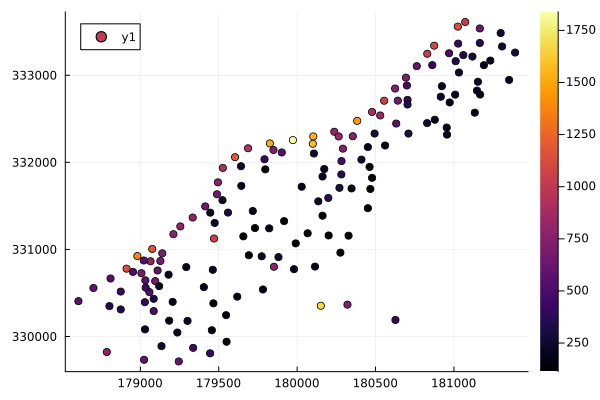

In [3]:
using Plots
x = convert(Vector{Float64}, df[:, :x])
y = convert(Vector{Float64}, df[:, :y])
zinc = df[:, :zinc]
scatter(x, y, zcolor = zinc)

Finally, in classic machine learning fashion, we split the data into a training
and a test set. We use about 85% of the data for training and the remaining 15%
for testing.

In [4]:
using Random
train_idcs = randsubseq(1:size(df, 1), 0.85)
test_idcs = [i for i = 1:size(df, 1) if isempty(searchsorted(train_idcs, i))]
X = [x y]
X_train = X[train_idcs, :]
X_test = X[test_idcs, :]
y_train = zinc[train_idcs]
y_test = zinc[test_idcs]
size(X_train, 1), size(X_test, 1)

(133, 22)

## Spatial Modelling
Matern Gaussian processes (GPs) are a powerful model class commonly used in
geostatistics for such data.
Unfortunately, without using any further tricks, GPs have a cubic runtime
complexity. As the size of the dataset grows, this quickly becomes
prohibitively expensive.
In the tutorial on Autoregressive models, we learned that GMRFs enable highly
efficient Gaussian inference through sparse precision matrices.
Can we combine the modelling power of GPs with the efficiency of GMRFs?

Yes, we can: [Lindgren2011](@cite) told us how.
It turns out that Matern processes may equivalently be interpreted as
solutions of certain stochastic partial differential equations (SPDEs).
If we discretize this SPDE appropriately -- for example using the finite
element method (FEM) -- we get a discrete GMRF approximation of a Matern
process. The approximation quality improves as the resolution of the FEM
mesh increases. If this all sounds overly complicated to you, fear not!
GaussianMarkovRandomFields.jl takes care of the technical details for you, so you can focus on the
modelling.

We start by generating a FEM mesh for our data. Internally, GaussianMarkovRandomFields.jl computes
a convex hull around the scattered data and then extends it slightly to
counteract effects from the boundary condition of the SPDE.

![This image depicts the mesh generated for the scattered data.](meuse_msh_fig.png)

The final output is a Ferrite.jl grid. We can also save the generated mesh,
e.g. to visualize it via Gmsh.

In [5]:
using GaussianMarkovRandomFields
points = zip(x, y)
grid = generate_mesh(points, 600.0, 100.0, save_path = "meuse.msh")

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Line)
Info    : [ 20%] Meshing curve 11 (Line)
Info    : [ 20%] Meshing curve 12 (Line)
Info    : [ 30%] Meshing curve 13 (Line)
Info    : [ 30%] Meshing curve 14 (Line)
Info    : [ 30%] Meshing curve 15 (Line)
Info    : [ 30%] Meshing curve 16 (Line)
Info    : [ 30%] Meshing curve 17 (Line)
Info    : [ 30%] Meshing curve 18 (Line)
Info    : [ 40%] Meshing curve 19 (Line)
Info    : [ 40%] Meshing curve 20 (Line)
Info    : [ 40%] Meshing curve 21 (Line)
Info    : [ 40%] Meshing curve 22 (Line)
Info    : [ 40%] Meshing curve 23 (Line)
Info    : [ 40%] Meshing curve 24 (Line)
I

Grid{2, Triangle, Float64} with 2143 Triangle cells and 1119 nodes

We can now create a FEM discretization, which consists of the grid, a choice
of basis functions, and a quadrature rule.

In [6]:
using Ferrite
ip = Lagrange{RefTriangle,1}()
qr = QuadratureRule{RefTriangle}(2)
disc = FEMDiscretization(grid, ip, qr)

FEMDiscretization
  grid: Grid{2, Triangle, Float64} with 2143 Triangle cells and 1119 nodes
  interpolation: Lagrange{RefTriangle, 1}()
  quadrature_rule: QuadratureRule{RefTriangle, Vector{Float64}, Vector{Vec{2, Float64}}}
  # constraints: 0


We now create a Matern SPDE and discretize it.
While we could specify the Matern SPDE in terms of its direct parameters κ
and ν, we here choose to specify it through the more easily interpretable
parameters `range` and `smoothness`.

In [7]:
spde = MaternSPDE{2}(range = 400.0, smoothness = 1)
u_matern = discretize(spde, disc)

GMRF{Float64, LinearMapWithSqrt{Float64, LinearMaps.WrappedMap{Float64, LinearAlgebra.Symmetric{Float64, SparseArrays.SparseMatrixCSC{Float64, Int64}}}, LinearMaps.WrappedMap{Float64, SparseArrays.SparseMatrixCSC{Float64, Int64}}, SparseArrays.SparseMatrixCSC{Float64, Int64}}, CholeskySolver{:default, TakahashiStrategy, Float64, LinearMapWithSqrt{Float64, LinearMaps.WrappedMap{Float64, LinearAlgebra.Symmetric{Float64, SparseArrays.SparseMatrixCSC{Float64, Int64}}}, LinearMaps.WrappedMap{Float64, SparseArrays.SparseMatrixCSC{Float64, Int64}}, SparseArrays.SparseMatrixCSC{Float64, Int64}}, SparseArrays.CHOLMOD.Factor{Float64, Int64}}}(
mean: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
precision: 1119×1119 LinearMapWithSqrt{Float64}
solver: CholeskySolver{:default, TakahashiStrategy, Float64, LinearMapWithSqrt{Float64, LinearMaps.WrappedMap{Float64, LinearAlgebra.Symmetric{Float64, SparseArrays.SparseMatrixCSC{Float64, Int64}}}, 

We can then condition the resulting Matern GMRF on the training data, where we
assume an inverse noise variance of 10 (i.e. a variance of 0.1).

In [8]:
Λ_obs = 10.0
A_train =
    evaluation_matrix(disc, [Tensors.Vec(X_train[i, :]...) for i = 1:size(X_train, 1)])
A_test = evaluation_matrix(disc, [Tensors.Vec(X_test[i, :]...) for i = 1:size(X_test, 1)])
u_cond = condition_on_observations(u_matern, A_train, Λ_obs, y_train)

LinearConditionalGMRF of size 1119 and solver LinearConditionalCholeskySolver{:default, TakahashiStrategy, Float64, LinearMaps.LinearCombination{Float64, Tuple{LinearMapWithSqrt{Float64, LinearMaps.WrappedMap{Float64, LinearAlgebra.Symmetric{Float64, SparseArrays.SparseMatrixCSC{Float64, Int64}}}, LinearMaps.WrappedMap{Float64, SparseArrays.SparseMatrixCSC{Float64, Int64}}, SparseArrays.SparseMatrixCSC{Float64, Int64}}, OuterProductMap{Float64}}}, SparseArrays.CHOLMOD.Factor{Float64, Int64}, LinearMaps.WrappedMap{Float64, SparseArrays.SparseMatrixCSC{Float64, Int64}}, LinearMaps.UniformScalingMap{Float64}}

We can evaluate the RMSE of the posterior mean on the test data:

In [9]:
rmse = (a, b) -> sqrt(mean((a .- b) .^ 2))
rmse(A_train * mean(u_cond), y_train), rmse(A_test * mean(u_cond), y_test)

(51.60352560323246, 191.80093500982446)

We can also visualize the posterior mean and standard deviation. To this end,
we write the corresponding vectors to a VTK file together with the grid data,
which can then be visualized in e.g. Paraview.

In [10]:
VTKGridFile("meuse_mean", disc.dof_handler) do vtk
    write_solution(vtk, disc.dof_handler, mean(u_cond))
end
using Distributions
VTKGridFile("meuse_std", disc.dof_handler) do vtk
    write_solution(vtk, disc.dof_handler, std(u_cond))
end

VTKGridFile for the closed file "meuse_std.vtu".

In the end, our posterior mean looks like this:
![Mean](meuse_mean.png)

And the posterior standard deviation looks like this:
![Std](meuse_std.png)

## Final note
We have seen how to combine the modelling power of GPs with the efficiency of
GMRFs. This is a powerful combination that allows us to model spatial data
efficiently and accurately.
Note that these models are still sensitive to the choice of hyperparameters,
i.e. the range and smoothness of the Matern process.
So it's quite likely that you may find better hyperparameters than the ones
used in this tutorial.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*